In [1]:
from centrex_tlf import states, hamiltonian, transitions, lindblad, couplings, utils
from centrex_tlf_julia_extension import lindblad_julia
import numpy as np
from scipy import constants as cst
# import tqdm
# import h5py

import matplotlib.pyplot as plt

c:\Users\Olivier\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\juliacall\__init__.py:271: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["legend.fontsize"] = 20

In [3]:
def doppler_shift(velocity, frequency):
    """calculate the doppler shifted frequency
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
    Returns:
        float: doppler shifted frequency in Hz
    """
    return frequency * (1 + velocity / cst.c)


def velocity_to_detuning(velocity, frequency=1.103e15, Γ=2 * np.pi * 1.56e6):
    """convert velocity to detuning in units of Γ
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
        Γ (float): Γ [2π⋅Hz]
    Returns:
        float: detuning in units of Γ
    """
    return (doppler_shift(velocity, frequency) - frequency) * 2 * np.pi / Γ


# save to HDF


def save_data(
    fname,
    run_name,
    scan_result,
    E_field,
    overwrite=True,
):
    with h5py.File(fname, "a") as f:
        if run_name in f.keys():
            if overwrite:
                del f[run_name]
        try:
            dset = f.create_dataset(run_name, data=scan_result)
            dset.attrs["electric_field"] = E_field
        except TypeError:
            print("Error saving data!")
            return data


def get_data(fname, run_name):
    with h5py.File(fname, "a") as f:
        dset = f[run_name]
        scan_result = np.array(dset)
    return scan_result

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=2, F1_excited=7 / 2, F_excited=3
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=2, F1_excited=7 / 2, F_excited=4
    ),
]

polarizations = [
    [couplings.polarization_X, couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Z],
]


transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.CoupledBasisState(
            J=2,
            F=3,
            F1=5 / 2,
            mF=2,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=1,
            electronic_state=states.ElectronicState.X,
        ),
        1
        * states.CoupledBasisState(
            J=2,
            F=3,
            F1=5 / 2,
            mF=0,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=1,
            electronic_state=states.ElectronicState.X,
        ),
    ],
    excited_mains=[
        1
        * states.CoupledBasisState(
            J=3,
            F=3,
            F1=7 / 2,
            mF=3,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        ),
        1
        * states.CoupledBasisState(
            J=3,
            F=4,
            F1=7 / 2,
            mF=1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        ),
    ],
)

In [5]:
def gen_multipass_para(npass, loss, fir_center, dz):
    pow_ord = []
    x_loc = []
    y_loc = []
    pow_para = 1 - loss
    multipass_ord = utils.multipass.multipass_prism_order(13)
    for i, pass_time in enumerate(multipass_ord):
        x_loc.append(fir_center + i * dz)
        y_loc.append(0.0)
        pow_ord.append(pow_para ** (pass_time - 1))
    return x_loc, y_loc, pow_ord


xloctions, yloctions, pow = gen_multipass_para(11, 0.15, 3.5e-3, 3.5e-3)
print(pow)

[1.0, 0.1673432436896142, 0.7224999999999999, 0.23161694628320306, 0.5220062499999999, 0.3205770882812499, 0.37714951562499993, 0.44370531249999995, 0.27249052503906246, 0.6141249999999999, 0.1968744043407226, 0.85, 0.14224175713617207]


In [6]:
v_to_Γ = utils.detuning.velocity_to_detuning(0)

odepars = lindblad_julia.odeParameters(
    # Ω0=(
    #     "Ωl0 * sqrt(phase_modulation(t, β, ωphase)) * multipass_2d_intensity(vz*t, 0.0, amplitudes, xlocs, ylocs, σz, σy)"
    # ),
    Ω0=(
        "phase_modulation(t, β1, ωphase1) * multipass_2d_rabi(vz*t, y0, amplitudes0, xlocs, ylocs, σz, σy, main_coupling0, 2.6675506e-30)"
    ),
    Ω1=(
        "phase_modulation(t, β2, ωphase2) * multipass_2d_rabi(vz*t, y0, amplitudes1, xlocs, ylocs, σz, σy, main_coupling1, 2.6675506e-30)"
    ),
    # laser
    dz=3.5e-3,  # spacing between multipass lasers
    Ωl0=1.0 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ} + δl0",  # detuning of the 1st laser [rad/s]
    δl0=0.0 * 2 * np.pi * 1e6,
    δ1=f"vx*{v_to_Γ} + δl1",  # detuning of the 2nd laser [rad/s]
    δl1=0.0 * 2 * np.pi * 1e6,
    amplitudes0=pow,
    amplitudes1=pow,
    xlocs=xloctions,
    ylocs=yloctions,
    main_coupling0=0.0,
    main_coupling1=0.0,
    y0=0.0,
    # laser phase modulation
    ωphase1=0.0 * 2 * np.pi * 1e6,  # laser phase modulation frequency [rad/s]
    β1=1.5,  # laser phase modulation depth [rad]
    ωphase2=0.0 * 2 * np.pi * 1e6,  # laser phase modulation frequency [rad/s]
    β2=2.0,  # laser phase modulation depth [rad]
    Pl0="resonant_polarization_modulation(t, γ, ωpol)",
    PX0="Pl0",
    PZ0="-sqrt(Pl0*Pl0-1j)",
    PZ1="Pl0",
    PX1="-sqrt(Pl0*Pl0-1j)",
    γ=np.pi / 2,
    ωpol=1.0 * np.pi * 1.6e6,
    ϕp=0.0,
    # molecules
    z0=0.0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0.0,
    σz=0.75e-3,
    σy=6e-3,
    laser_center=3.5e-3,
)

In [7]:
%%time
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    E=np.array([0, 0, 250]),
)


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
c:\Users\Olivier\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\centrex_tlf\states\find_states.py:564: UserWarning: Low overlap detected for approximate states at indices [0, 1, 5, 6]. Overlaps: [0.4861743653439869, 0.49677874368793146, 0.4967787435322296, 0.486174365260556]. The approximate states may not be well-represented in the eigenstate basis.
  indices = find_exact_states_indices(
c:\Users\Olivier\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\centrex_tlf\states\find_states.py:564: UserWarning: Low overlap detected for approximate states at indices [0, 1, 7, 8]. Overlaps: [0.48645690448001455, 0.49343338632053024, 0.49343338627636113, 0.4864569044624937]. The approximate states may not be well-represented in the eigenstate basis.
  indices = find_exact_states_indices(
c:\Users\Olivier\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\

CPU times: total: 28 s
Wall time: 34.1 s


In [8]:
%%time
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars, n_procs=4
)

CPU times: total: 1min 47s
Wall time: 3min 45s


In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 3, F1 = 7/2, F = 3>","|B, J = 3, F1 = 7/2, F = 4>"
states,,
"|X, J = 1>",0.000031,0.000010
"|X, J = 2>",0.323673,0.318652
"|X, J = 3>",0.379163,0.387412
"|X, J = 4>",0.284830,0.281155
"|X, J = 5>",0.012303,0.012771


In [10]:
obe_system.H_symbolic

Matrix([
[-419110791216.135,                                               0,                                               0,                                               0,                                               0,                                               0,                                                 0,                                               0,                                               0,                                               0,                                               0,                                                0,                                               0,                                               0,                                               0,                                               0,                                               0,                                               0,                                               0,                                               0,                                      

In [11]:
# qn_select = states.QuantumSelector(J=1,F1=3/2,F=2,mF=2, electronic=states.ElectronicState.X)
qn_select = states.QuantumSelector(J=2, electronic=states.ElectronicState.X)
ground_idx = qn_select.get_indices(obe_system.QN)
ρ = np.zeros(obe_system.H_symbolic.shape, dtype=complex)
for idx in ground_idx:
    ρ[idx, idx] = 1 / ground_idx.size

In [12]:
dz = 0.75e-3 * 4  # x diamater of the laser
dy = 6e-3 * 4  # y diamater of the laser
power0 = 80.0e-3
power1 = power0 * 0.3
# power1 = 80.e-3

odepars.σz = dz / 4
odepars.σy = dy / 4
odepars.main_coupling0 = np.abs(obe_system.couplings[0].main_coupling)
odepars.main_coupling1 = np.abs(obe_system.couplings[1].main_coupling)
odepars.amplitudes0 = power0 * np.array(pow) / (2 * np.pi * dz / 4 * dy / 4)
odepars.amplitudes1 = power1 * np.array(pow) / (2 * np.pi * dz / 4 * dy / 4)

In [13]:
t_end = 0.05 / 184
odepars.δl0 = 18.5 * 2 * np.pi * 1e6
odepars.ωphase1 = 17.5 * 2 * np.pi * 1e6
odepars.ωphase2 = 17.5 * 2 * np.pi * 1e6
odepars.ωpol = 0.5 * 2 * np.pi * 1e6
# odepars.ωphase2 = 11.5*2*np.pi*1e6
odepars.δl1 = -6.5 * 2 * np.pi * 1e6
odepars.β1 = 1.5
odepars.β2 = odepars.β1
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, t_end))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6, maxiters=100000)

In [15]:
results = lindblad_julia.do_simulation_single(problem, config)

In [ ]:
from centrex_tlf_julia_extension.lindblad_julia.utils_julia import jl

julia_packages = ["BenchmarkTools"]
jl.seval("using Pkg")
for pkg in julia_packages:
    if not bool(jl.seval(f'isnothing(Base.find_package("{pkg}")) ? false : true')):
        print(f"Installing Julia package: {pkg}")
        jl.Pkg.add(pkg)
jl.seval("using BenchmarkTools: @btime, @benchmark")

In [17]:
_ = jl.seval("du = similar(ρ)")
_ = jl.seval("t = 0.0")

In [18]:
jl.seval("@benchmark Lindblad_rhs!(du, ρ, p, t)")

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  18.000 μs … 194.100 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.850 μs ±   9.600 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▃▁▁ ▂▂            ▂                                        ▁
  █████████▇▆▆▆▅▅▆▇▆▆▆█▇█▇▇▇▇▇▅██▇▆▆▅▅▄▅▃▄▃▄▃▄▃▄▃▁▃▁▁▃▃▃▃▃▃▄▁▃ █
  18 μs         Histogram: log(frequency) by time      78.2 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
print(odepars.Ω0)

phase_modulation(t, β1, ωphase1) * multipass_2d_rabi(vz*t, y0, amplitudes0, xlocs, ylocs, σz, σy, main_coupling0, 2.6675506e-30)


In [22]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
excited_idx = qn_select_excited.get_indices(obe_system.QN)

nT = results.t.shape[0]
nS = results.y.T.shape[1]

print("number of time bins=", nT)
print("number of states=", nS)

number of time bins= 51921
number of states= 40


In [23]:
# J1_idx = states.QuantumSelector(J=1,electronic=states.ElectronicState.X).get_indices(obe_system.QN)
J0_idx = states.QuantumSelector(J=0, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)
J1_idx = states.QuantumSelector(J=1, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)

J2_others_idx = []
for stuff in states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN):
    if stuff not in ground_idx:
        J2_others_idx.append(stuff)

J3_idx = states.QuantumSelector(J=3, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)
J4_idx = states.QuantumSelector(J=4, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)
J5_idx = states.QuantumSelector(J=5, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)

In [24]:
# J1_idx = states.QuantumSelector(J=1,electronic=states.ElectronicState.X).get_indices(obe_system.QN)
J0_idx = states.QuantumSelector(J=0, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)
J1_others_idx = []
for stuff in states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN):
    if stuff not in ground_idx:
        J1_others_idx.append(stuff)

J2_idx = states.QuantumSelector(J=2, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)

J3_idx = states.QuantumSelector(J=3, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)
J4_idx = states.QuantumSelector(J=4, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)
J5_idx = states.QuantumSelector(J=5, electronic=states.ElectronicState.X).get_indices(
    obe_system.QN
)

C:\Users\Olivier\AppData\Local\Temp\ipykernel_57532\1484014409.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nphotons = np.trapz(results.y[excited_idx], x=results.t).sum() * hamiltonian.Γ


state clean up efficiency = 0.9994204527386973


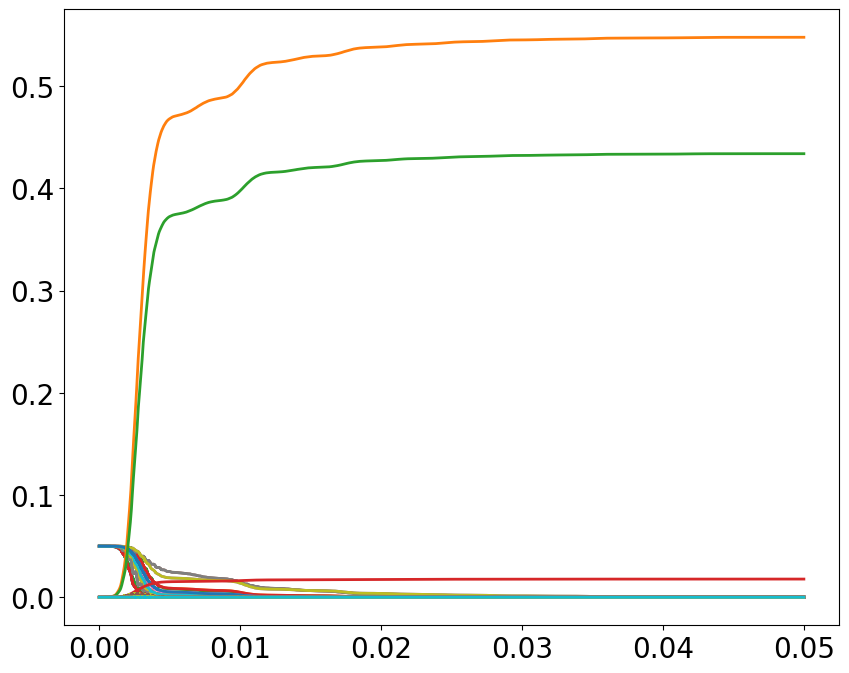

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(results.t * odepars.vz, results.y.T, lw=2)

clean_up_eff = np.sum(results.y.T[-1, ground_idx])
nphotons = np.trapz(results.y[excited_idx], x=results.t).sum() * hamiltonian.Γ
print("state clean up efficiency =", 1 - clean_up_eff)

In [26]:
ground_final = []
for idx in ground_idx:
    state_label = obe_system.QN[idx].largest
    ax.plot(
        results.t[:] * odepars.vz, results.y.T[:, idx], lw=2, label=str(state_label)
    )
    ground_final.append(results.y.T[:, idx])

remainder in ground state = 0.0005795472613027237
remainder in J=0 = []
remainder in J=2, other state = 0.0
remainder in J=1 = [4.37600215e-05]
remainder in J=3 = [0.54771382]
remainder in J=4 = [0.43385435]
remainder in J=5 = [0.01780852]


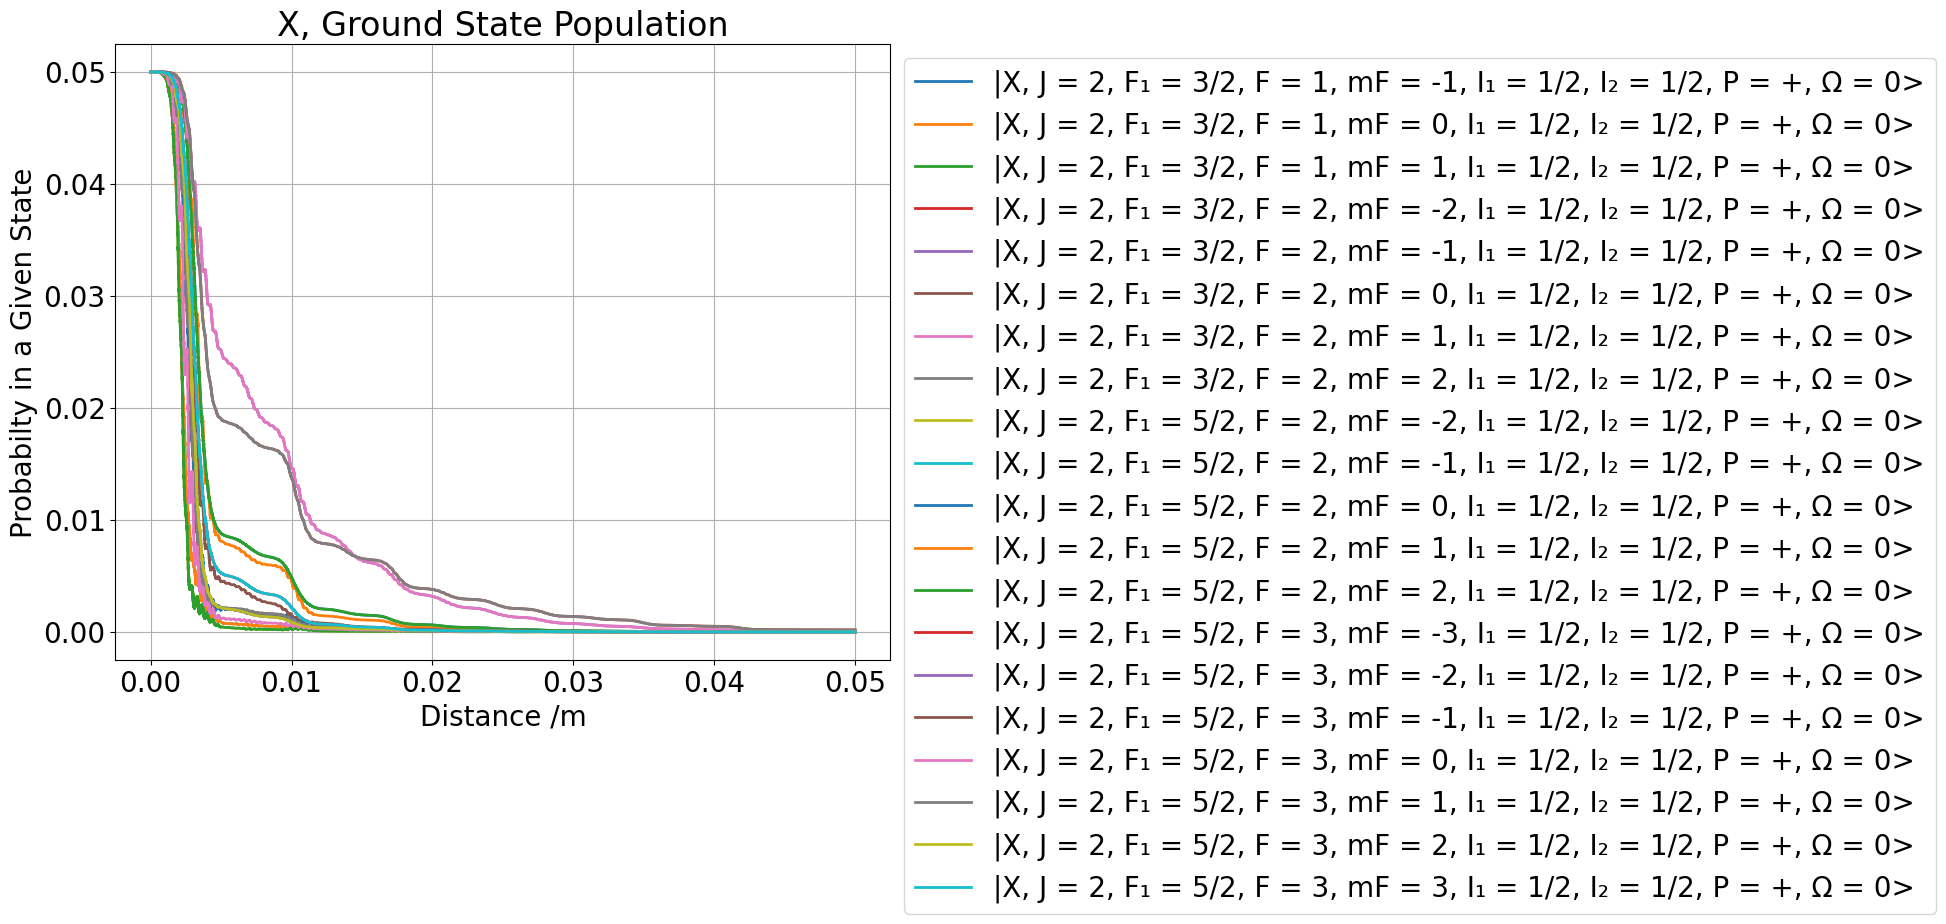

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

stop_dist = 0.05
stop = np.argmin((abs(results.t - stop_dist / odepars.vz)))

plot_idx = [ground_idx[1], ground_idx[3], ground_idx[5], ground_idx[7]]
# plot_idx = [ground_idx[0]]
ground_final = []
for idx in ground_idx[:]:
    state_label = obe_system.QN[idx].largest
    ax.plot(
        results.t[:] * odepars.vz, results.y.T[:, idx], lw=2, label=str(state_label)
    )
    ground_final.append(results.y.T[-1, idx])
ax.set_title("X, Ground State Population")
ax.set_ylabel("Probabilty in a Given State")
ax.set_xlabel("Distance /m")
ax.legend(bbox_to_anchor=[1, 1])
ax.grid(True)

total_final = np.sum(ground_final)
print("remainder in ground state =", total_final)
print("remainder in J=0 =", results.y.T[stop, J0_idx])

print("remainder in J=2, other state =", np.sum(results.y.T[stop, J2_others_idx]))
print("remainder in J=1 =", results.y.T[stop, J1_idx])

print("remainder in J=3 =", results.y.T[stop, J3_idx])
print("remainder in J=4 =", results.y.T[stop, J4_idx])
print("remainder in J=5 =", results.y.T[stop, J5_idx])

remainder in ground state = 4.376002149492848e-05
remainder in J=0 = []
remainder in J=2, other state = 0.0
remainder in J=1 = [4.37600215e-05]
remainder in J=3 = [0.54771382]
remainder in J=4 = [0.43385435]
remainder in J=5 = [0.01780852]


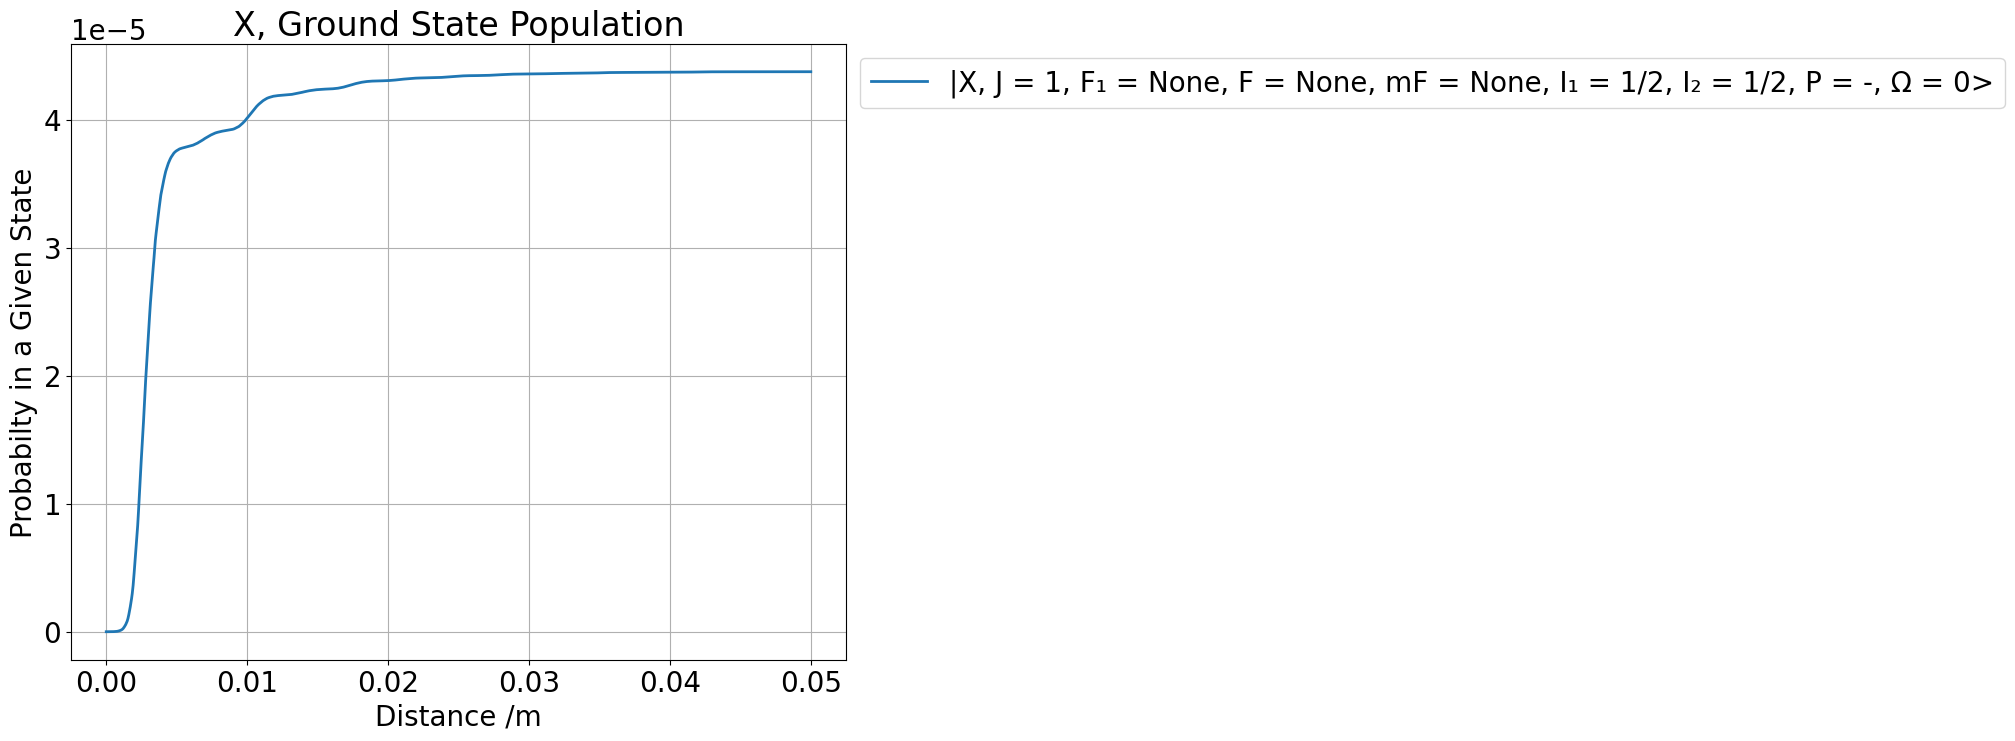

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

stop_dist = 0.05
stop = np.argmin((abs(results.t - stop_dist / odepars.vz)))

plot_idx = [J1_others_idx[0]]
# plot_idx = [ground_idx[0]]
ground_final = []
for idx in plot_idx[:]:
    state_label = obe_system.QN[idx].largest
    ax.plot(
        results.t[:] * odepars.vz, results.y.T[:, idx], lw=2, label=str(state_label)
    )
    ground_final.append(results.y.T[-1, idx])
ax.set_title("X, Ground State Population")
ax.set_ylabel("Probabilty in a Given State")
ax.set_xlabel("Distance /m")
ax.legend(bbox_to_anchor=[1, 1])
ax.grid(True)

total_final = np.sum(ground_final)
print("remainder in ground state =", total_final)
print("remainder in J=0 =", results.y.T[stop, J0_idx])

print("remainder in J=2, other state =", np.sum(results.y.T[stop, J2_others_idx]))
print("remainder in J=1 =", results.y.T[stop, J1_idx])

print("remainder in J=3 =", results.y.T[stop, J3_idx])
print("remainder in J=4 =", results.y.T[stop, J4_idx])
print("remainder in J=5 =", results.y.T[stop, J5_idx])

#### laser 2 frequency scan with different laser 1 power

In [29]:
detunings1 = np.linspace(-40, 40, 41) * 2 * np.pi * 1e6

In [30]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_everystep=False
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, t_end))

scan_values = [detunings1]
parameters = ["δl1"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem, parameters=parameters, scan_values=scan_values
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

AttributeError: Julia: cannot assign a value to imported variable BenchmarkTools.params from module Main

In [25]:
print(ensemble_config)

OBEEnsembleProblemConfig(method='Tsit5()', abstol=1e-07, reltol=0.0001, dt=1e-08, callback=None, dtmin=0, maxiters=100000, saveat=[], save_everystep=False, save_idxs=None, progress=False, dense=False, distributed_method='EnsembleDistributed()', trajectories=None)


In [26]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

In [31]:
scan_res = lindblad_julia.get_results_parameter_scan(ensemble_problem)

ValueError: cannot reshape array of size 65600 into shape (41,40)

In [ ]:
scan_result = np.real(np.einsum("ijjk->ijk", np.array(Main.eval("sol.u"))))
scan_result_ground = np.sum(scan_result[:, 1:21, 1], axis=1)

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [ ]:
min_value_idx = np.argmin(scan_result_ground)
print(detunings1[min_value_idx] / (2 * np.pi * 1e6))

-6.0


Text(0, 0.5, 'Total Population in J2')

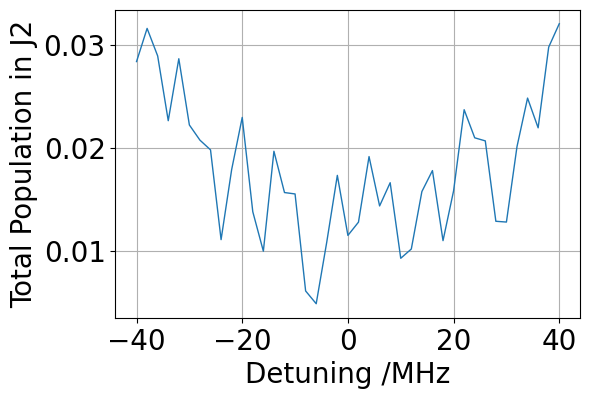

In [ ]:
start = 0
end = -1
fig, ax = plt.subplots(figsize=[6, 4])
ax.plot(detunings1[:] / 2 / np.pi / 1e6, scan_result_ground[:], lw=1)
ax.grid()

ax.set_xlabel("Detuning /MHz")
ax.set_ylabel("Total Population in J2")

#### laser 2 detuning & EOM frequency scan

In [ ]:
detunings1 = np.linspace(-20, 0, 41) * 2 * np.pi * 1e6
EOM_fre = np.linspace(0, 20, 81) * 2 * np.pi * 1e6

In [ ]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_everystep=False
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, t_end))

scan_values = [detunings1, EOM_fre]
parameters = ["δl1", "ωphase2"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem, parameters=parameters, scan_values=scan_values
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

ProblemFunction(name='prob_func', function='\n@everywhere function prob_func(prob, i, repeat)\n    remake(prob, p = (0.0035,9801769.079200154,116238928.18282235,params[i,1],[2829.42121052,  473.48452313, 2044.2568246 ,  655.34190053,\n   1476.97555578,  907.04761319, 1067.11483905, 1255.42922241,\n    770.99047121, 1737.61830091,  557.04061545, 2405.00802894,\n    402.46184466],[848.82636316, 142.04535694, 613.27704738, 196.60257016,\n   443.09266673, 272.11428396, 320.13445171, 376.62876672,\n   231.29714136, 521.28549027, 167.11218464, 721.50240868,\n   120.7385534 ],[0.0035, 0.007, 0.0105, 0.014, 0.0175, 0.021, 0.0245, 0.028, 0.0315, 0.035, 0.038500000000000006, 0.042, 0.045500000000000006],[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],0.09395446261202724,0.21655996256552343,0.0,109955742.87564276,1.5,params[i,2],1.5,1.5707963267948966,3141592.653589793,0.0,0.0,184,0.0,0.00075,0.006,0.0035))\nend\n')

In [ ]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)
scan_result = np.real(np.einsum("ijjk->ijk", np.array(Main.eval("sol.u"))))
scan_result_ground = np.sum(scan_result[:, 1:21, 1], axis=1)

In [ ]:
scan_result_ground_reshape = np.array(scan_result_ground).reshape(
    len(EOM_fre), len(detunings1)
)
print(scan_result_ground_reshape.min())

0.0003583253458924921


In [ ]:
min_value_idx = list(
    np.unravel_index(
        scan_result_ground_reshape.argmin(), scan_result_ground_reshape.shape
    )
)
print(detunings1[min_value_idx[1]] / (2 * np.pi * 1e6))
print(EOM_fre[min_value_idx[0]] / (2 * np.pi * 1e6))

-12.0
12.500000000000002


In [ ]:
save_data(
    fname="cleanup_J2_2laser.hdf",
    run_name="scan_det2&eom2",
    scan_result=scan_result_ground_reshape,
    E_field=250,
)

Text(0.5, 1.0, 'laser power:60mW+18mW')

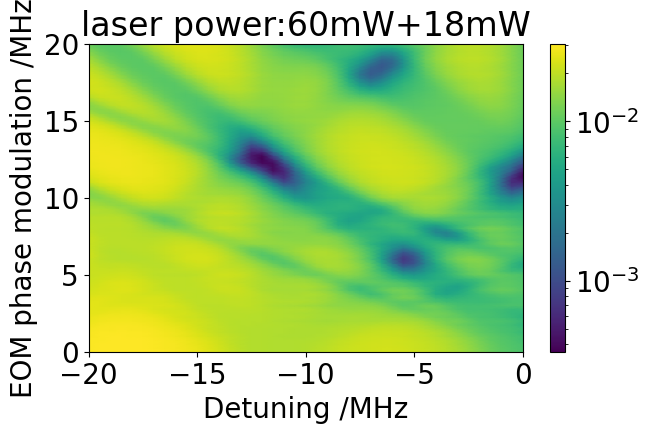

In [ ]:
import matplotlib

fig, ax = plt.subplots(figsize=[7, 4])
cax = ax.pcolormesh(
    detunings1 / 2 / np.pi / 1e6,
    EOM_fre / 2 / np.pi / 1e6,
    scan_result_ground_reshape,
    shading="gouraud",
    norm=matplotlib.colors.LogNorm(),
)
cbar = fig.colorbar(cax)
ax.set_xlabel("Detuning /MHz")
ax.set_ylabel("EOM phase modulation /MHz")
ax.set_title(
    "laser power:" + str(int(power0 * 1e3)) + "mW" + "+" + str(int(power1 * 1e3)) + "mW"
)

#### laser 2 detuning & laser 1 power scan

In [ ]:
detunings1 = np.linspace(-20, 20, 81) * 2 * np.pi * 1e6
power_scan = np.linspace(10, 110, 6) * 1e-3

In [ ]:
result = []
resonance_fre = []
for power in power_scan:
    scan_result = []
    scan_result_ground = []
    print(power)

    odepars.amplitudes0 = list(power * np.array(pow) / (2 * np.pi * dz / 4 * dy / 4))

    ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
        method="Tsit5()", save_everystep=False
    )

    problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, t_end))

    scan_values = [detunings1]
    parameters = ["δl1"]

    ensemble_problem = lindblad_julia.OBEEnsembleProblem(
        problem=problem, parameters=parameters, scan_values=scan_values
    )

    lindblad_julia.setup_problem_parameter_scan(
        ensemble_problem,
    )

    lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)
    scan_result = np.real(np.einsum("ijjk->ijk", np.array(Main.eval("sol.u"))))
    scan_result_ground = np.sum(scan_result[:, 1:21, 1], axis=1)

    result.append(scan_result_ground)
    min_value_idx = np.argmin(scan_result_ground)
    resonance_fre.append(detunings1[min_value_idx] / (2 * np.pi * 1e6))

0.01
0.03
0.05
0.07
0.09
0.11


In [ ]:
file_name = "cleanup_J2_2laser.hdf"
run_name = "scan laser 1 power & laser 2 detuning"
save_data(file_name, run_name, scan_result=result)

TypeError: save_data() missing 1 required positional argument: 'E_field'

In [ ]:
print(scan_result_ground)

[0.0091629  0.00876704 0.00808145 0.0069661  0.00542906 0.00376954
 0.00292542 0.00312226 0.00432986 0.0060224  0.00740746 0.00837445
 0.00892754 0.00914851 0.00912653 0.00892936 0.00862604 0.00839532
 0.008332   0.00837666 0.00834263 0.00805815 0.00742908 0.00640646
 0.0050102  0.00345682 0.00201355 0.00124769 0.00121495 0.00140827
 0.0017214  0.00253783 0.00382373 0.00512891 0.00608816 0.00672014
 0.00695871 0.00685067 0.00625938 0.00520758 0.00387028 0.00312637
 0.00339238 0.00463007 0.0061992  0.00741605 0.00824922 0.00870624
 0.00885725 0.0088128  0.00860122 0.0083029  0.00813288 0.00811812
 0.00822227 0.00829684 0.00821375 0.00786497 0.00721861 0.00618777
 0.00481734 0.00332057 0.00220218 0.00183991 0.00187386 0.00219477
 0.00316233 0.00452358 0.00575308 0.00656751 0.00702923 0.00709364
 0.00680111 0.00602283 0.0048146  0.00345944 0.00278744 0.00303769
 0.00422512 0.00586961 0.00724172]
